In [1]:
"""
Plot example image chunks from reference data
"""

import os, sys, time, glob
import geopandas as gpd
import pandas as pd
import rioxarray as rxr
import xarray as xr
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt
import gc 

from fiona.crs import from_epsg
from shapely.geometry import box

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataloader import default_collate
from torchvision import transforms, utils
from torchsat.models.classification import resnet18

# Custom functions
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.rcParams['font.family'] = 'Times New Roman'

# Projection information
wgs = from_epsg(4326)
proj = from_epsg(32618)
albers = from_epsg(5070)

print(f'Projected CRS: {albers}')

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping'

print("Successfully imported all packages!")

Projected CRS: EPSG:5070
Successfully imported all packages!


In [2]:
# Function to plot image samples

In [3]:
def plot_image_chunks(class_ds, rgb_ds, class_mapping, band_mapping, n_cols,
                      out_file=os.path.join(maindir,'figures/Figure2_dc-denver_image_chunks.png'), 
                      figsize=(10,10), labelsize=10):
    """
    Plots a single example image chunk for each class with columns representing different bands.
    The first column is an RGB true-color composite with subsequent columns being classification bands.
    
    Args:
    - dataset: The dataset containing the image chunks and labels used in classification.
    - rgb_ds: a second dataloader with just RGB imagery for both AOIs
    - class_mapping: Dictionary mapping class codes to class labels.
    - band_mapping: Dictionary mapping band number to band name.
    - n_cols: Number of columns to include in the plot (number of bands)
    """
    # Get the device for accessing torch items
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # get device for gpu or cpu

    # Retrieve the sample codes
    sample_codes = list(class_mapping.keys())
    n_rows = len(sample_codes) # number of classes = number of rows
    n_bands = n_cols # number of bands should be the same as the number of columns
    n_cols = n_bands + 1 # Add one for the RGB column
    
    # Store examples for each class for both image datasets
    class_samples_dict = {code: None for code in sample_codes}
    rgb_samples_dict = {code: None for code in sample_codes}
    
    # Iterate over the DataLoader to find at least one sample for each class
    for class_batch, rgb_batch in zip(class_ds, rgb_ds):
        # Ensure good batches
        class_batch = make_good_batch(class_batch) 
        rgb_batch = make_good_batch(rgb_batch)

        # Define the image samples and labels
        images_class, codes_class = class_batch['image'].to(device), class_batch['code'].to(device)
        images_rgb, codes_rgb = rgb_batch['image'].to(device), rgb_batch['code'].to(device)
        
        # Ensure the class codes match between both batches
        assert torch.equal(codes_class, codes_rgb), "Mismatch between RGB and classification DataLoaders"

        # Iterate over class codes and find a sample for each
        for code, label in class_mapping.items():
            if class_samples_dict[code] is None:  # Check if a sample hasn't been collected yet
                cls_idxs = (codes_class == code).nonzero(as_tuple=True)[0]
                if len(cls_idxs) > 0:
                    idx = np.random.choice(cls_idxs)  # Select a random index for this class
                    class_samples_dict[code] = images_class[idx].cpu().numpy()  # Store the classification sample
                    rgb_samples_dict[code] = images_rgb[idx]  # Store the corresponding RGB sample
        
        # Exit the loop if we have samples for all classes
        if all(sample is not None for sample in class_samples_dict.values()):
            break
    
    print(f"Class dictionary: {class_samples_dict.keys()}")

    # Plot the collected samples
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, squeeze=False)
    plt.rcParams['font.family'] = 'Times New Roman'
    
    # Create image plots with rows as classes and columns as bands
    for row_idx, (code, label) in enumerate(class_mapping.items()):
        print(f"\tSetting plot for sample image [{code, label}].")
        # Plot the RGB in the first column
        rgb_image = rgb_samples_dict[code]
        if rgb_image is not None:
            rgb_image = rgb_image.permute(1, 2, 0).numpy()  # Change the dimensions to HWC for plotting
            # Scale the image to [0, 255] range for display
            rgb_image = (255 * (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())).astype(np.uint8)
            axes[row_idx, 0].imshow(rgb_image)
            axes[row_idx, 0].axis('off')
        else:
            print(f"No RGB sample available for class {label}.")
        
        # Populate the remaining columns with classification bands
        class_image = class_samples_dict[code]
        if class_image is None:
            print(f"No samples available for class {label}.")
            continue
        
        for band_idx, (band_num, band_name) in enumerate(band_mapping.items()):
            band_image = class_image[band_idx, :, :]  # Select the specific band
            axes[row_idx, band_idx + 1].imshow(band_image, cmap='gray')  # Use grayscale for single-band images
            axes[row_idx, band_idx + 1].axis('off')
            
            # Add title for the first row of each band
            if row_idx == 0:
                axes[0, band_idx + 1].set_title(f"{band_name}", fontsize=labelsize)
                if band_idx == 0:
                    axes[0, 0].set_title('RGB', fontsize=labelsize)

    # Set the row labels as class codes
    for row_idx, (code, label) in enumerate(class_mapping.items()):
        axes[row_idx, 0].set_ylabel(str(label), fontsize=labelsize)
        axes[row_idx, 0].yaxis.set_label_coords(-0.1, 0.5)
    
    # plt.subplots_adjust(top=0.95, left=0.15)
    
    plt.savefig(out_file, dpi=300, bbox_inches='tight')
    
    plt.show()

print("Plotting function ready !!!")

Plotting function ready !!!


In [4]:
# Load the reference data for DC
ref_fp = os.path.join(maindir,'data/spatial/mod/dc_data/training/dc_data_reference_footprints.gpkg')
ref_dc = gpd.read_file(ref_fp)
ref_dc = ref_dc.to_crs(albers)
ref_dc.head()

,uid,class_code,description,areaUTMsqft,lotSizeSqft,geometry
0,1CS,CS,Composition Shingle,357.783709,5574.0,"POLYGON ((1618024.537 1931734.332, 1618025.567..."
1,3CS,CS,Composition Shingle,918.640862,1111.0,"POLYGON ((1618808.974 1929995.232, 1618810.631..."
2,9CS,CS,Composition Shingle,1383.414170,4222.0,"POLYGON ((1623885.735 1919398.71, 1623891.16 1..."
3,19CS,CS,Composition Shingle,836.410297,3450.0,"POLYGON ((1628717.795 1926593.614, 1628720.363..."
4,27CS,CS,Composition Shingle,330.514264,4352.0,"POLYGON ((1623015.124 1919789.523, 1623019.675..."


In [5]:
# Load the reference data for Denver
ref_fp = os.path.join(maindir,'data/spatial/mod/denver_data/training/denver_data_reference_footprints.gpkg')
ref_denver = gpd.read_file(ref_fp)
ref_denver = ref_denver.to_crs(albers)
ref_denver.head()

,uid,class_code,description,areaUTMsqft,lotSizeSqft,geometry
0,78TL,TL,Tile,271.028875,4710.0,"MULTIPOLYGON (((-761234.666 1892255.157, -7612..."
1,269TL,TL,Tile,3885.053236,22307.0,"MULTIPOLYGON (((-760349.372 1891832.63, -76033..."
2,490TL,TL,Tile,2018.268605,6250.0,"MULTIPOLYGON (((-761461.065 1891666.741, -7614..."
3,497TL,TL,Tile,273.843801,6370.0,"MULTIPOLYGON (((-760668.873 1891805.943, -7606..."
4,537TL,TL,Tile,281.649002,6000.0,"MULTIPOLYGON (((-761279.614 1891782.525, -7612..."


In [6]:
print(ref_dc.class_code.value_counts())
print(ref_denver.class_code.value_counts())

class_code
CS    37133
ME    36864
SL    15267
UR     1279
WS     1152
TL      924
SH      783
Name: count, dtype: int64
class_code
CS    86561
WS    10642
AP     8117
TL     2843
CN     2757
SL      230
TG      228
Name: count, dtype: int64


In [7]:
dc_keep = ['ME', 'SL', 'UR', 'SH'] # majority classes from DC
denver_keep = ['CS', 'WS', 'AP', 'TL', 'CN', 'TG'] # majority classes from Denver
# Keep majority classes from each region for example plots
ref_dc_sub = ref_dc[ref_dc['class_code'].isin(dc_keep)]
ref_denver_sub = ref_denver[ref_denver['class_code'].isin(denver_keep)]

In [8]:
# Combine the two reference data sets
ref = pd.concat([ref_dc_sub, ref_denver_sub], ignore_index=True)
list(ref.class_code.unique())

['ME', 'SL', 'UR', 'SH', 'TL', 'WS', 'CN', 'AP', 'TG', 'CS']

In [9]:
ref.class_code.value_counts()

class_code
CS    86561
ME    36864
SL    15267
WS    10642
AP     8117
TL     2843
CN     2757
UR     1279
SH      783
TG      228
Name: count, dtype: int64

In [10]:
# Identify areas with "pure" material types for examples

In [11]:
print(ref.crs)

PROJCS["NAD83 / Conus Albers",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","5070"]]


In [12]:
# Create centroids
ref_pt = ref.copy()
ref_pt = ref_pt.to_crs(albers) # wgs for both ROIs
ref_pt['geometry'] = ref_pt['geometry'].centroid

# Define the window size and half window (for boxes)
window_size = 78
half_window = window_size / 2

training_windows = [] # image windows with >50% of specific roof type
training_roof_types = [] # roof type codes for valid windows

# Loop through each footprint individually
for geom, roof_type in zip(ref.geometry, ref['class_code']):
    # calculate the image window as footprint buffer
    centroid = geom.centroid
    window = box(centroid.x - half_window, centroid.y - half_window,
                 centroid.x + half_window, centroid.y + half_window)

    # Intersect with centroids to get class count within window
    intersect = ref_pt[ref_pt.intersects(window)]
    
    # Get the total count and count for the class
    total_count = len(intersect)
    class_count = len(intersect[intersect['class_code'] == roof_type])

    # Check if there is at least 50% of the roof type in that window
    if total_count > 0 and (class_count / total_count) > 0.50:
        training_windows.append(geom)
        training_roof_types.append(roof_type)

    del intersect, window, centroid

# Create a GeoDataFrame for the training windows with roof types
ref_windows = gpd.GeoDataFrame({
    'geometry': training_windows, 
    'class_code': training_roof_types
}, crs=ref.crs)

print("Spatial filtering complete.")

Spatial filtering complete.


In [13]:
ref_windows.class_code.value_counts()

class_code
CS    85879
ME    36254
SL    14186
WS     9675
AP     8002
CN     2647
TL     2479
SH      377
UR      278
TG      172
Name: count, dtype: int64

In [14]:
# Perform balanced sampling (random undersampling)
ref_bal = balance_sampling(ref_windows, ratio=5, strategy='undersample')
ref_bal = ref_bal.sort_values(by='class_code', ascending=True).reset_index(drop=True)
# Create a numeric code for the training data frame
ref_bal['code'], _ = pd.factorize(ref_bal['class_code'])
ref_bal.class_code.value_counts()

class_code
AP    860
CN    860
CS    860
ME    860
SL    860
TL    860
WS    860
SH    377
UR    278
TG    172
Name: count, dtype: int64

In [15]:
# Create a dictionary mapping class_code to code
class_mapping = dict(zip(ref_bal['code'], ref_bal['class_code']))
print(class_mapping)

{0: 'AP', 1: 'CN', 2: 'CS', 3: 'ME', 4: 'SH', 5: 'SL', 6: 'TG', 7: 'TL', 8: 'UR', 9: 'WS'}


In [16]:
for row_idx, (code, label) in enumerate(class_mapping.items()):
    print(row_idx, code, label)

0 0 AP
1 1 CN
2 2 CS
3 3 ME
4 4 SH
5 5 SL
6 6 TG
7 7 TL
8 8 UR
9 9 WS


In [17]:
# Load the image data

In [18]:
# Load the image stack
stack_da_fp_dc = os.path.join(maindir, 'data/spatial/mod/dc_data/planet-data/dc_0623_psscene8b_final_norm.tif')
stack_da_dc = rxr.open_rasterio(stack_da_fp_dc, mask=True, cache=False).squeeze()
# Load the image data for denver as well
stack_da_fp_denver = os.path.join(maindir, 'data/spatial/mod/denver_data/planet-data/denver_0815_psscene8b_final_norm.tif')
stack_da_denver = rxr.open_rasterio(stack_da_fp_denver, mask=True, cache=False).squeeze()

In [19]:
# Extract band names
band_desc = stack_da_dc.attrs['long_name']
band_idx = stack_da_dc.band.values
n_bands = len(band_desc)
# Create the dictionary mapping long names to band numbers
band_mapping = dict(zip(band_idx, band_desc))
print(band_mapping)

{1: 'nir', 2: 'NDBIbg', 3: 'NDBIrg', 4: 'NISI', 5: 'MNF1', 6: 'NISI5x5'}


In [20]:
for band_idx, band_name in band_mapping.items():
    print(band_idx-1, band_name)

0 nir
1 NDBIbg
2 NDBIrg
3 NISI
4 MNF1
5 NISI5x5


In [21]:
del stack_da_dc, stack_da_denver
gc.collect()

144

In [22]:
# Create the RGB data

In [23]:
rgb_fp_dc = os.path.join(maindir, 'data/spatial/mod/dc_data/planet-data/dc_0623_psscene8b_rgb.tif')
rgb_fp_denver = os.path.join(maindir, 'data/spatial/mod/denver_data/planet-data/denver_0815_psscene8b_rgb.tif')

if not os.path.exists(rgb_fp_denver):
    # Load the Planet SuperDove image data for Denver and D.C.
    ps_fp_dc = os.path.join(maindir, 'data/spatial/mod/dc_data/planet-data/dc_0623_psscene8b.tif')
    ps_fp_denver = os.path.join(maindir, 'data/spatial/mod/denver_data/planet-data/denver_0815_psscene8b.tif')
    
    # Select the RGB and save the new image data
    rgb_da_dc = rxr.open_rasterio(ps_fp_dc, mask=True, cache=False).squeeze().sel(band=[6, 4, 2])
    rgb_da_denver = rxr.open_rasterio(ps_fp_denver, mask=True, cache=False).squeeze().sel(band=[6, 4, 2])
    # Update the 'long_name' attribute
    long_names = ['red', 'green', 'blue']
    rgb_da_dc.attrs['long_name'] = tuple(long_names)
    rgb_da_denver.attrs['long_name'] = tuple(long_names)
    
    # Save these images out
    
    rgb_da_dc.rio.to_raster(
        rgb_fp_dc, compress='zstd', zstd_level=9,
        dtype='float64', driver='GTiff')
    rgb_da_denver.rio.to_raster(
        rgb_fp_denver, compress='zstd', zstd_level=9,
        dtype='float64', driver='GTiff')
    
    print(f"Successfuly saved RGB images:\n\t{rgb_fp_dc}\n{rgb_fp_denver}")
    del rgb_da_denver, rgb_da_dc
    gc.collect()
else:
    print("RGB images exists!")

RGB images exists!


In [24]:
# Create a DataLoader for both AOIs and combine them

window_size = 78 # window size used in Resnet-18 training

# Washington, D.C.
ref_bal_dc = ref_bal[ref_bal['class_code'].isin(dc_keep)]
ref_bal_dc = ref_bal_dc.to_crs(from_epsg(32618)) # convert back to UTM
# Classification bands
image_ds_dc = RoofImageDatasetPlanet(
    ref_bal_dc[['geometry', 'code']], 
    img_path=stack_da_fp_dc, 
    img_dim=window_size, 
    n_bands=n_bands
)
# RGB true-color
rgb_ds_dc = RoofImageDatasetPlanet(
    ref_bal_dc[['geometry', 'code']], 
    img_path=rgb_fp_dc, 
    img_dim=window_size, 
    n_bands=3 # RGB
)

# Denver, Colorado
ref_bal_denver = ref_bal[ref_bal['class_code'].isin(denver_keep)]
ref_bal_denver = ref_bal_denver.to_crs(from_epsg(32613)) # convert back to UTM
# Classification bands
image_ds_denver = RoofImageDatasetPlanet(
    ref_bal_denver[['geometry', 'code']], 
    img_path=stack_da_fp_denver, 
    img_dim=window_size, 
    n_bands=n_bands
)
# RGB true-color
rgb_ds_denver = RoofImageDatasetPlanet(
    ref_bal_denver[['geometry', 'code']], 
    img_path=rgb_fp_denver, 
    img_dim=window_size, 
    n_bands=3 # RGB
)

# Ensure all samples are available
bs = len(image_ds_dc) + len(image_ds_denver)

# Combine the datasets for loader
image_ds_combined = DataLoader(image_ds_dc + image_ds_denver, batch_size=bs, shuffle=False)
rgb_ds_combined = DataLoader(rgb_ds_dc + rgb_ds_denver, batch_size=bs, shuffle=False)

print("Data loaded!")

Data loaded!


In [25]:
print(class_mapping)

{0: 'AP', 1: 'CN', 2: 'CS', 3: 'ME', 4: 'SH', 5: 'SL', 6: 'TG', 7: 'TL', 8: 'UR', 9: 'WS'}


Class dictionary: dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
	Setting plot for sample image [(0, 'AP')].
	Setting plot for sample image [(1, 'CN')].
	Setting plot for sample image [(2, 'CS')].
	Setting plot for sample image [(3, 'ME')].
	Setting plot for sample image [(4, 'SH')].
	Setting plot for sample image [(5, 'SL')].
	Setting plot for sample image [(6, 'TG')].
	Setting plot for sample image [(7, 'TL')].
	Setting plot for sample image [(8, 'UR')].
	Setting plot for sample image [(9, 'WS')].


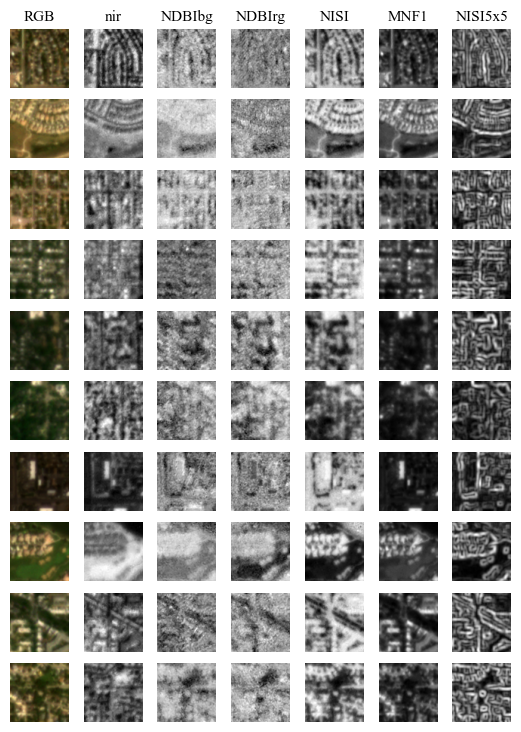

Total elapsed time: 5.32 minutes.


In [26]:
t0 = time.time()

# Create a plot of image chunks
out_png = os.path.join(maindir,'figures/Figure2_dc-denver_image_chunks.png')
plot_image_chunks(
    image_ds_combined, rgb_ds_combined, class_mapping, band_mapping, 
    n_cols=6, out_file=out_png, figsize=(6.5,9), labelsize=11
)

t1 = (time.time() - t0) / 60
print(f"Total elapsed time: {t1:.2f} minutes.")

In [ ]:
gc.collect()